In [1]:
import os
import glob

import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

from fbprophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, scorer

from sklearn import preprocessing

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.cluster import KMeans

# Please modifty file path firstly
file_path = '/Users/Eddy/Desktop/MBTA/'

#### Merge CSV files from MBTA Website

In [2]:
# Merge files
if os.path.exists(file_path + 'data.csv')  == False:
    for inputfile in glob.glob(file_path + '*.csv'):
        a = pd.read_csv(inputfile, header=None, low_memory=False)
        a.to_csv(file_path + 'data.csv', mode='a',index=False,header=False)

# Read csv files
raw = pd.read_csv(file_path + 'data.csv', index_col='service_date', parse_dates=True)

# Drop useless columns
raw.drop(['gtfs_route_short_name', 'gtfs_route_long_name', 'gtfs_route_desc',
          'route_category', 'metric_type'], axis=1, inplace=True)
raw.head(10)

,gtfs_route_id,mode_type,peak_offpeak_ind,otp_numerator,otp_denominator,cancelled_numerator
service_date,,,,,,
2015-01-01,741,Bus,OFF_PEAK,1127.0,1301.0,NaN
2015-01-01,742,Bus,OFF_PEAK,615.0,804.0,NaN
2015-01-01,751,Bus,OFF_PEAK,1329.0,1570.0,NaN
2015-01-01,749,Bus,OFF_PEAK,2848.0,3113.0,NaN
2015-01-01,CR-Fairmount,Commuter Rail,PEAK,0.0,0.0,0.0
2015-01-01,CR-Fairmount,Commuter Rail,OFF_PEAK,33.0,34.0,0.0
2015-01-01,CR-Fitchburg,Commuter Rail,PEAK,0.0,0.0,0.0
2015-01-01,CR-Fitchburg,Commuter Rail,OFF_PEAK,15.0,16.0,0.0
2015-01-01,CR-Worcester,Commuter Rail,OFF_PEAK,18.0,18.0,0.0


#### Delete Error Data & Calculate Reliability Percent

In [3]:
# numerator & denominator = 0 means no data record today
raw = raw[raw.otp_numerator > 0]
raw = raw[raw.otp_denominator > 0]

# calculate the reliability
raw['reliability'] = 100 * (raw['otp_numerator'] / raw['otp_denominator'])
raw.head()

,gtfs_route_id,mode_type,peak_offpeak_ind,otp_numerator,otp_denominator,cancelled_numerator,reliability
service_date,,,,,,,
2015-01-01,741,Bus,OFF_PEAK,1127.0,1301.0,NaN,86.625673
2015-01-01,742,Bus,OFF_PEAK,615.0,804.0,NaN,76.492537
2015-01-01,751,Bus,OFF_PEAK,1329.0,1570.0,NaN,84.649682
2015-01-01,749,Bus,OFF_PEAK,2848.0,3113.0,NaN,91.487311
2015-01-01,CR-Fairmount,Commuter Rail,OFF_PEAK,33.0,34.0,0.0,97.058824


#### Green-B Line Reliability Comparison (Peak / Off-Peak)

In [4]:
# Using Green-B line for example
greenb = raw[raw.gtfs_route_id=='Green-B']
greenb = greenb[['peak_offpeak_ind', 'reliability']]
greenb.sort_index(inplace=True)
greenb.head()

,peak_offpeak_ind,reliability
service_date,,
2018-01-01,PEAK,75.991399
2018-01-01,OFF_PEAK,66.641052
2018-01-02,PEAK,72.127594
2018-01-02,OFF_PEAK,75.499145
2018-01-03,OFF_PEAK,73.632415


In [5]:
# Create pivot table, only change the dataframe structure
greenb = greenb.pivot_table(index=greenb.index, values='reliability', 
                            columns='peak_offpeak_ind', aggfunc=np.mean)
greenb.head()

peak_offpeak_ind,OFF_PEAK,PEAK
service_date,,
2018-01-01,66.641052,75.991399
2018-01-02,75.499145,72.127594
2018-01-03,73.632415,72.370818
2018-01-04,65.886202,61.732012
2018-01-05,69.618782,69.328308


Text(0, 0.5, 'Daily Reliability Percent')

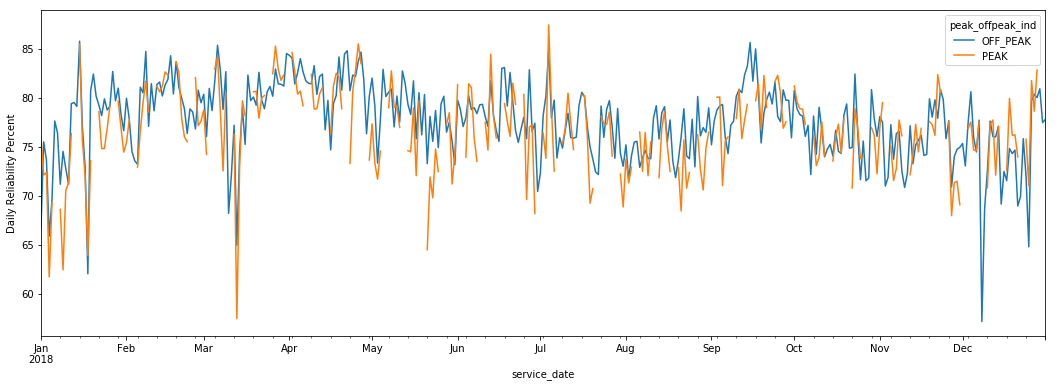

In [6]:
# show daily reliability figures
fig, ax = plt.subplots(figsize=(18,6))
greenb.plot(style='-', ax=ax)
plt.ylabel('Daily Reliability Percent')

'''
Notes: there is no peak time in weekends
Normally, the Green-B's performace is better in off-peak time
'''

#### Show Everyday Reliability of Bus, Commuter Rail and Rail (Subway)

In [7]:
data = raw

# Pivot table, for all three traffic mode
data = data.pivot_table(index=data.index, values='reliability', 
                        columns='mode_type', aggfunc=np.mean)
data.head()

mode_type,Bus,Commuter Rail,Rail
service_date,,,
2015-01-01,71.387627,96.902719,NaN
2015-01-02,68.407700,95.928483,NaN
2015-01-03,70.873196,94.176722,NaN
2015-01-04,72.449728,97.073413,NaN
2015-01-05,69.745918,90.799830,NaN


#### Calculate Reliability for Every Week

In [8]:
weekly = data.resample('W').mean()
weekly_mean = pd.DataFrame(weekly)
weekly_mean.head()

mode_type,Bus,Commuter Rail,Rail
service_date,,,
2015-01-04,70.779563,96.020334,NaN
2015-01-11,70.533211,88.132863,NaN
2015-01-18,69.095201,92.456236,NaN
2015-01-25,68.353561,91.651903,NaN
2015-02-01,52.380031,71.791847,NaN


#### Draw Weekly Reliability Figure

Text(0, 0.5, 'Weekly Reliability Percent')

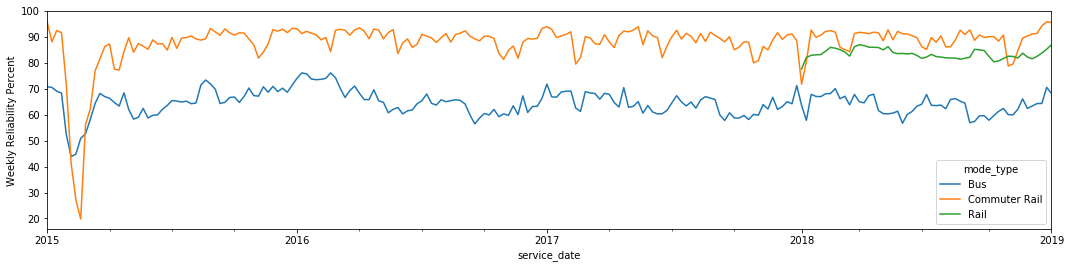

In [9]:
# MBTA provides subway Performance Data begin from 2018
fig, ax = plt.subplots(figsize=(18,4))
weekly_mean.plot(style='-', ax=ax)
plt.ylabel('Weekly Reliability Percent')

'''
MBTA doesn't begin to provide subway's data until Year 2018.
Every winter, all traffic performance will go down obviously.
We can find obvious weekly and monthly trend in the figure.
'''

#### Select Bus Data to Forecast Prediction

In [10]:
bus = data[['Bus']]
bus.reset_index(inplace=True)
bus.columns=['ds', 'y']
bus.tail()

,ds,y
1455,2018-12-27,70.801216
1456,2018-12-28,69.572885
1457,2018-12-29,72.305093
1458,2018-12-30,72.603818
1459,2018-12-31,68.239101


#### Prophet & Fit Data Set

In [12]:
m = Prophet(yearly_seasonality=True, 
            weekly_seasonality=True, 
            daily_seasonality=False)
m.fit(bus);

#### Prediction & Result

In [13]:
# Generate future date: next one year
future = m.make_future_dataframe(periods=365)

forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1820,2019-12-27,63.395562,58.553645,72.156742,59.216033,67.860125,1.749781,1.749781,1.749781,-1.946085,-1.946085,-1.946085,3.695866,3.695866,3.695866,0.0,0.0,0.0,65.145343
1821,2019-12-28,63.395058,63.750479,77.486043,59.188268,67.879183,7.008009,7.008009,7.008009,2.969698,2.969698,2.969698,4.038311,4.038311,4.038311,0.0,0.0,0.0,70.403068
1822,2019-12-29,63.394555,63.767181,77.943625,59.176777,67.898242,7.168510,7.168510,7.168510,2.797333,2.797333,2.797333,4.371177,4.371177,4.371177,0.0,0.0,0.0,70.563064
1823,2019-12-30,63.394051,63.608448,77.128545,59.167300,67.922528,6.715273,6.715273,6.715273,2.024612,2.024612,2.024612,4.690662,4.690662,4.690662,0.0,0.0,0.0,70.109324
1824,2019-12-31,63.393547,60.489536,73.799622,59.152055,67.951065,3.809182,3.809182,3.809182,-1.183947,-1.183947,-1.183947,4.993129,4.993129,4.993129,0.0,0.0,0.0,67.202730


#### Draw Figures

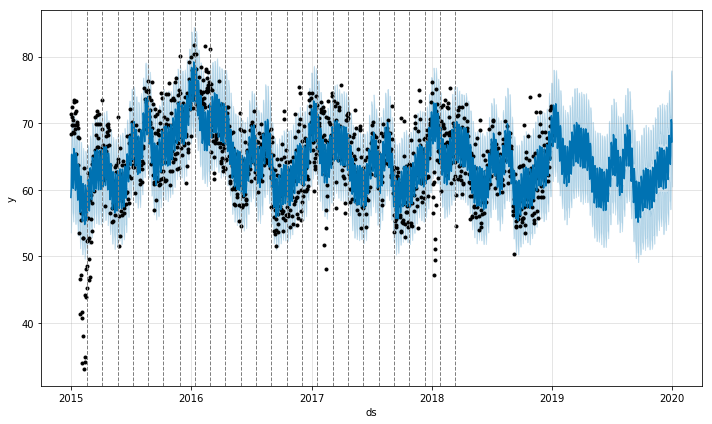

In [14]:
'''
Every year shows the same trend. like W-M-V shape.
'''
fig1 = m.plot(forecast)

for cp in m.changepoints:
    plt.axvline(cp, c='gray', ls='--', lw=1)

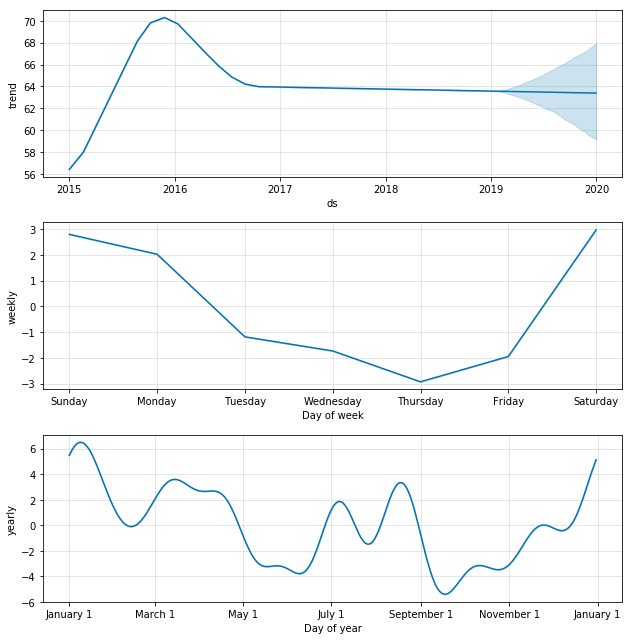

In [15]:
'''
Show the predicted trend of the Year 2020
Show the weekly trend, weenkends have high performance becasue of off-peak time
'''
fig2 = m.plot_components(forecast)

#### Linear Regression & Logistic Regression Data Pre-processing

In [16]:
# Select columns we need to use
mbta = data[['Bus', 'Commuter Rail', 'Rail']]
mbta.reset_index(inplace=True)

# Modifty columns' name
mbta.columns=['date', 'bus', 'commuter rail', 'subway']
mbta.set_index('date', inplace=True)

mbta.head()

,bus,commuter rail,subway
date,,,
2015-01-01,71.387627,96.902719,NaN
2015-01-02,68.407700,95.928483,NaN
2015-01-03,70.873196,94.176722,NaN
2015-01-04,72.449728,97.073413,NaN
2015-01-05,69.745918,90.799830,NaN


#### Merge Holiday Data

In [17]:
# choose 2015-2018 year
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2015','2018')

holidays_series = pd.Series(1, index=holidays, name='HOLIDAY')

# join together
mbta = mbta.join(holidays_series)
mbta['HOLIDAY'].fillna(0, inplace=True)

mbta.head()

,bus,commuter rail,subway,HOLIDAY
date,,,,
2015-01-01,71.387627,96.902719,NaN,1.0
2015-01-02,68.407700,95.928483,NaN,0.0
2015-01-03,70.873196,94.176722,NaN,0.0
2015-01-04,72.449728,97.073413,NaN,0.0
2015-01-05,69.745918,90.799830,NaN,0.0


#### Merge Weather Data

In [18]:
# read csv file
raw_weather = pd.read_csv(file_path + 'weather/weather.csv', 
                          index_col='DATE', parse_dates=True)

raw_weather.drop(['STATION', 'TMIN', 'TMAX'], axis=1, inplace=True)

# select date
weather = raw_weather['2015/1':'2018/12']

# join
mbta = mbta.join(weather)
mbta.head()

,bus,commuter rail,subway,HOLIDAY,PRCP,SNOW,TAVG
date,,,,,,,
2015-01-01,71.387627,96.902719,NaN,1.0,0.00,0.0,26.0
2015-01-02,68.407700,95.928483,NaN,0.0,0.00,0.0,34.0
2015-01-03,70.873196,94.176722,NaN,0.0,0.62,1.4,28.0
2015-01-04,72.449728,97.073413,NaN,0.0,0.57,0.0,38.0
2015-01-05,69.745918,90.799830,NaN,0.0,0.00,0.0,40.0


#### Merge Month Data

In [19]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(12):
    mbta[months[i]] = (mbta.index.month == (i+1)).astype(int)

mbta.head()

,bus,commuter rail,subway,HOLIDAY,PRCP,SNOW,TAVG,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
date,,,,,,,,,,,,,,,,,,,
2015-01-01,71.387627,96.902719,NaN,1.0,0.00,0.0,26.0,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-02,68.407700,95.928483,NaN,0.0,0.00,0.0,34.0,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-03,70.873196,94.176722,NaN,0.0,0.62,1.4,28.0,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-04,72.449728,97.073413,NaN,0.0,0.57,0.0,38.0,1,0,0,0,0,0,0,0,0,0,0,0
2015-01-05,69.745918,90.799830,NaN,0.0,0.00,0.0,40.0,1,0,0,0,0,0,0,0,0,0,0,0


#### Merge Week Data

In [20]:
days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
for i in range(7):
    mbta[days[i]] = (mbta.index.dayofweek == i).astype(int)

mbta.head()

,bus,commuter rail,subway,HOLIDAY,PRCP,SNOW,TAVG,Jan,Feb,Mar,...,Oct,Nov,Dec,Mon,Tue,Wed,Thu,Fri,Sat,Sun
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,71.387627,96.902719,NaN,1.0,0.00,0.0,26.0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2015-01-02,68.407700,95.928483,NaN,0.0,0.00,0.0,34.0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2015-01-03,70.873196,94.176722,NaN,0.0,0.62,1.4,28.0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2015-01-04,72.449728,97.073413,NaN,0.0,0.57,0.0,38.0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2015-01-05,69.745918,90.799830,NaN,0.0,0.00,0.0,40.0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Linear Regression & Prediction for Bus

In [21]:
column_names = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan','Feb','Mar','Apr','May',
                'Jun','Jul','Aug','Sep','Oct','Nov','Dec','PRCP','HOLIDAY','SNOW','TAVG']

linear_bus = mbta[['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan','Feb','Mar','Apr','May',
                   'Jun','Jul','Aug','Sep','Oct','Nov','Dec','PRCP','HOLIDAY','SNOW','TAVG','bus']]
# drop naa
linear_bus = linear_bus.dropna()

x = linear_bus[column_names]
y = linear_bus[['bus']]

# fit values
model = LinearRegression(fit_intercept=False)
model.fit(x, y)

# prediction
linear_bus['predicted'] = model.predict(x)
linear_bus.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jan,Feb,Mar,...,Sep,Oct,Nov,Dec,PRCP,HOLIDAY,SNOW,TAVG,bus,predicted
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0.00,1.0,0.0,26.0,71.387627,70.114327
2015-01-02,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.00,0.0,0.0,34.0,68.407700,66.324622
2015-01-03,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0.62,0.0,1.4,28.0,70.873196,71.409567
2015-01-04,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0.57,0.0,0.0,38.0,72.449728,72.291677
2015-01-05,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.00,0.0,0.0,40.0,69.745918,70.303986


#### Draw Comparison Figure

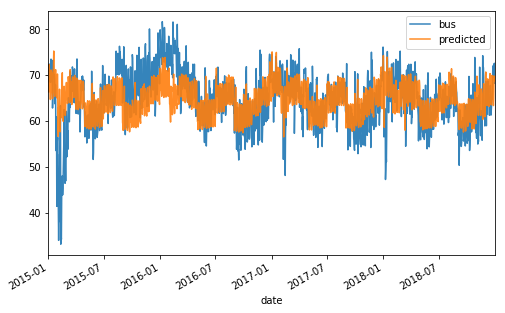

In [22]:
linear_bus[['bus', 'predicted']].plot(alpha=0.9, figsize=(8,5));

'''
Linear Regression really simulates the trend of the whole years
But there still has large error compared with test data
'''

Mean squared error: 24.64
Variance score: 0.33


Mon        41.492667
Tue        38.563591
Wed        37.957069
Thu        36.770474
Fri        37.679568
Sat        42.829158
Sun        42.597679
Jan        27.702886
Feb        23.949668
Mar        26.140459
Apr        24.602299
May        19.865811
Jun        20.023519
Jul        23.010389
Aug        24.607465
Sep        19.068092
Oct        20.262052
Nov        23.005207
Dec        25.652360
PRCP        1.645790
HOLIDAY     4.920487
SNOW       -0.656264
TAVG        0.027711
dtype: float64

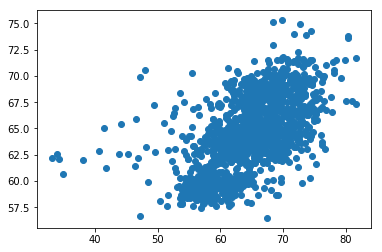

In [27]:
plt.scatter(linear_bus.bus, linear_bus.predicted);

'''
From this figure, it's difficult to find a linear relation.
So it's not a good idea to use linear regression.
Then I will try Logistic Regression.
'''

#Show Model Params & Error & Score
params = pd.Series(np.reshape(model.coef_,23), index=column_names)

print("Mean squared error: {:.2f}".format(
        mean_squared_error(linear_bus['bus'], linear_bus['predicted'])))

print("Variance score: {:.2f}".format(
    r2_score(linear_bus['bus'], linear_bus['predicted'])))

params

#### Logistic Regression & Prediction for Bus

In [28]:
# Show detail info about bus data
mbta['bus'].dropna().describe()

count    1455.000000
mean       64.509048
std         6.066176
min        33.101526
25%        60.986798
50%        64.537554
75%        68.546183
max        81.692557
Name: bus, dtype: float64

#### Define Performance

In [29]:
logistic_bus = mbta[['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan','Feb','Mar',
                     'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','PRCP',
                     'HOLIDAY','SNOW','TAVG','bus']].copy()
logistic_bus.dropna()

# define performance based on reliability value
logistic_bus['performance'] = logistic_bus['bus'].apply(lambda x: 'good' if x > 70 else 
                                                        ('bad' if x < 50 else 'delay'))
logistic_bus.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jan,Feb,Mar,...,Sep,Oct,Nov,Dec,PRCP,HOLIDAY,SNOW,TAVG,bus,performance
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0.00,1.0,0.0,26.0,71.387627,good
2015-01-02,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0.00,0.0,0.0,34.0,68.407700,delay
2015-01-03,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0.62,0.0,1.4,28.0,70.873196,good
2015-01-04,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0.57,0.0,0.0,38.0,72.449728,good
2015-01-05,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0.00,0.0,0.0,40.0,69.745918,delay


#### Logistic Regression

In [30]:
# input
x = np.array(logistic_bus[['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan',
                           'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',
                           'Oct','Nov','Dec','PRCP','HOLIDAY','SNOW','TAVG']])
x

array([[ 0. ,  0. ,  0. , ...,  1. ,  0. , 26. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 34. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  1.4, 28. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 49. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 32. ],
       [ 1. ,  0. ,  0. , ...,  0. ,  0. , 36. ]])

In [31]:
# output/target
y = np.array(logistic_bus[['performance']])
y

array([['good'],
       ['delay'],
       ['good'],
       ...,
       ['good'],
       ['good'],
       ['delay']], dtype=object)

In [32]:
# fit input and output
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial')
logreg.fit(x, y)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
# performance probility
performance_probs = logreg.predict_proba(x)
performance_probs[:5]

array([[0.02345942, 0.13951445, 0.83702613],
       [0.00657242, 0.75409031, 0.23933727],
       [0.00791372, 0.27289541, 0.71919087],
       [0.00137385, 0.26292297, 0.73570318],
       [0.0026218 , 0.58139732, 0.41598088]])

In [34]:
# predicted performance
performance_pred = logreg.predict(x)
logistic_bus['performance_pred'] = performance_pred
logistic_bus[['performance', 'performance_pred']].head(10)

,performance,performance_pred
date,,
2015-01-01,good,good
2015-01-02,delay,delay
2015-01-03,good,good
2015-01-04,good,good
2015-01-05,delay,delay
2015-01-06,delay,delay
2015-01-07,good,delay
2015-01-08,delay,good
2015-01-09,delay,delay


Score:  0.8294520547945206
Accuracy:  0.8294520547945206


'\nLinear Score: 0.33\nLogistic Score: 0.8294520547945206\nOverall, we can find in this data set, using Logistic Regression is better than Linear\n'

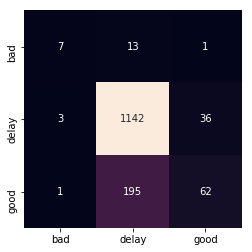

In [35]:
# show score
print ("Score: ", logreg.score(x, y))

# show accuracy score
print ("Accuracy: ", metrics.accuracy_score(y, performance_pred))

# show confusion matrix
sns.heatmap(metrics.confusion_matrix(y, performance_pred), 
            square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['bad','delay','good'],
            yticklabels=['bad','delay','good'])

'''
Linear Score: 0.33
Logistic Score: 0.8294520547945206
Overall, we can find in this data set, using Logistic Regression is better than Linear
'''

#### Principal Component Analysis (find most important attributes)

In [36]:
# For Logistic Regression, find which attributes are important
pca_data = logistic_bus[['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan',
                         'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep',
                         'Oct','Nov','Dec','PRCP','HOLIDAY','SNOW','TAVG','performance']]
pca_data.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jan,Feb,Mar,...,Aug,Sep,Oct,Nov,Dec,PRCP,HOLIDAY,SNOW,TAVG,performance
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0.00,1.0,0.0,26.0,good
2015-01-02,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0.00,0.0,0.0,34.0,delay
2015-01-03,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0.62,0.0,1.4,28.0,good
2015-01-04,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0.57,0.0,0.0,38.0,good
2015-01-05,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.00,0.0,0.0,40.0,delay


In [37]:
# Data Normalization, only used for draw figures, not for PCA
min_max_scaler = preprocessing.MinMaxScaler()

pca_normalization = pca_data.copy()

pca_normalization['PRCP'] = min_max_scaler.fit_transform(pca_normalization[['PRCP']])
pca_normalization['TAVG'] = min_max_scaler.fit_transform(pca_normalization[['TAVG']])
pca_normalization['SNOW'] = min_max_scaler.fit_transform(pca_normalization[['SNOW']])

pca_normalization.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jan,Feb,Mar,...,Aug,Sep,Oct,Nov,Dec,PRCP,HOLIDAY,SNOW,TAVG,performance
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0.000000,1.0,0.000000,0.292135,good
2015-01-02,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0.000000,0.0,0.000000,0.382022,delay
2015-01-03,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0.231343,0.0,0.063348,0.314607,good
2015-01-04,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0.212687,0.0,0.000000,0.426966,good
2015-01-05,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.000000,0.0,0.000000,0.449438,delay


In [38]:
# rebuild the dataframe
pca = pd.melt(pca_normalization, id_vars=['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','performance'], var_name='attribute', value_name='value')
pca.head()

,Mon,Tue,Wed,Thu,Fri,Sat,Sun,Jan,Feb,Mar,...,Jun,Jul,Aug,Sep,Oct,Nov,Dec,performance,attribute,value
0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,good,PRCP,0.000000
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,delay,PRCP,0.000000
2,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,good,PRCP,0.231343
3,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,good,PRCP,0.212687
4,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,delay,PRCP,0.000000


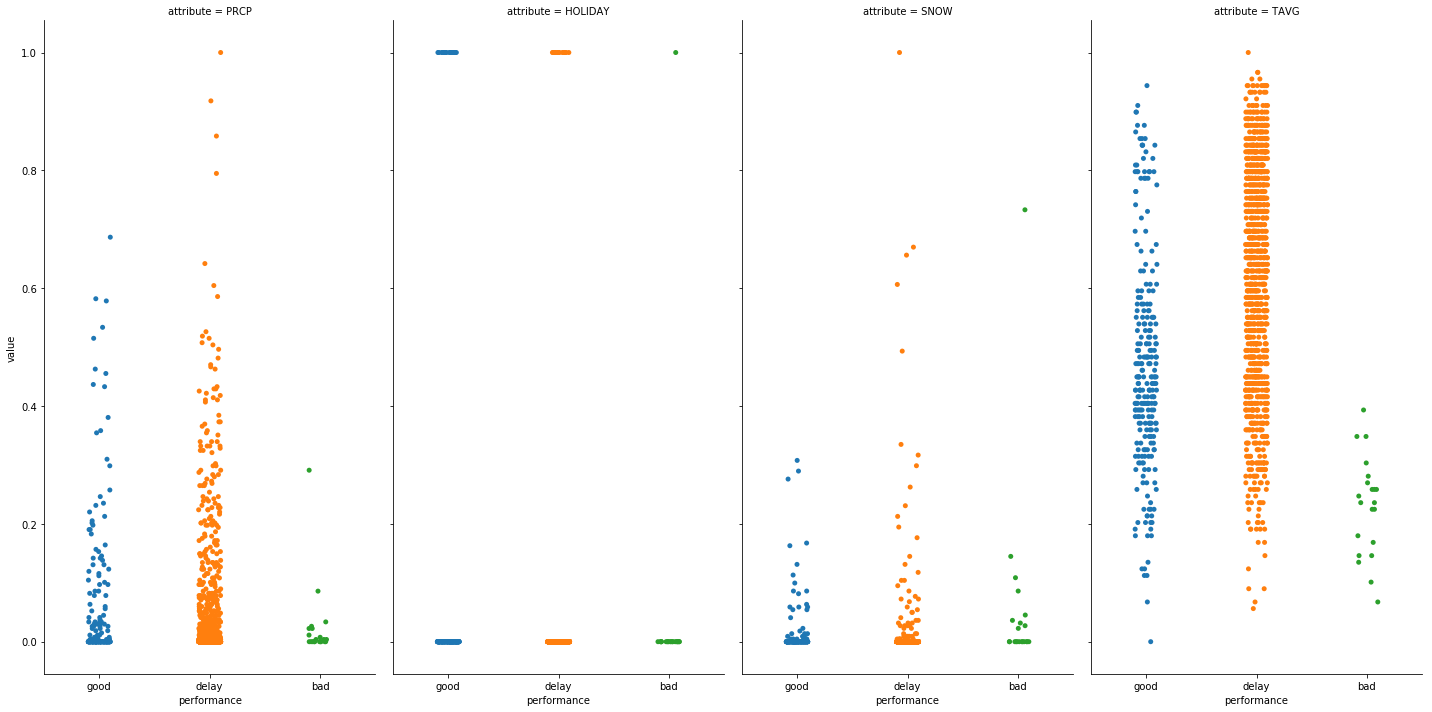

In [39]:
# Show every attributes' relational figures
sns.catplot(x="performance", y="value", hue="performance", height=10, aspect=0.5,
                 col="attribute", data=pca);

'''
After data normalization, the figures show relation with different features.
Rain, Snow, Average Temperature really reflect the change of bus performance.
'''

In [40]:
# input value for PCA
x = np.array(pca_data[['Mon','Tue','Wed','Thu','Fri','Sat','Sun','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','PRCP','HOLIDAY','SNOW','TAVG']])
x

array([[ 0. ,  0. ,  0. , ...,  1. ,  0. , 26. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 34. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  1.4, 28. ],
       ...,
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 49. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. , 32. ],
       [ 1. ,  0. ,  0. , ...,  0. ,  0. , 36. ]])

In [41]:
# target value for PCA
y = np.array(pca_data[['performance']])
y

array([['good'],
       ['delay'],
       ['good'],
       ...,
       ['good'],
       ['good'],
       ['delay']], dtype=object)

In [42]:
# Set up component number
pca = PCA(n_components=4)

# fit input value
x_r = pca.fit(x).transform(x)
x_r

array([[26.45467932, -0.5154102 ,  0.06207709, -0.6074949 ],
       [18.4562259 , -0.42229266,  0.07889616,  0.38283294],
       [24.4747129 ,  0.95239933, -0.2015191 , -0.36769772],
       ...,
       [ 3.45790039, -0.22946937, -0.17564354, -0.43944274],
       [20.45434469, -0.47007726, -0.10646694, -0.08733709],
       [16.45549588, -0.36549084,  0.81061639,  0.14426714]])

In [43]:
pca.inverse_transform(x_r)[0:2]

array([[ 1.12773616e-01, -2.06479599e-01,  1.12423445e-01,
         5.00668955e-01, -8.63059387e-02,  3.88237269e-01,
         1.78682253e-01,  2.39688115e-01,  1.92044837e-01,
         1.96372110e-01,  1.28251133e-01,  2.57532160e-02,
        -1.76962432e-02, -8.15191756e-02, -7.95049060e-02,
        -1.99276652e-02,  6.21936577e-02,  1.34785355e-01,
         2.19559566e-01,  3.01622559e-02,  2.81672431e-02,
         9.97203764e-03,  2.59997669e+01],
       [ 2.64867939e-01,  3.01668263e-01,  1.34711862e-01,
        -1.05011254e-01,  3.02085475e-01, -1.96827392e-02,
         1.21360453e-01,  1.93123382e-01,  1.59451377e-01,
         1.65320426e-01,  1.05103181e-01,  6.47124179e-02,
         7.22090675e-03, -2.66392718e-02, -2.95495887e-02,
         3.32966382e-03,  7.08747973e-02,  1.27111158e-01,
         1.59941550e-01,  1.20773898e-01,  4.24117151e-02,
        -1.11606537e-02,  3.39979085e+01]])

In [44]:
ratio = pd.Series(pca.explained_variance_ratio_, index=['PRCP', 'HOLIDAY', 'SNOW', 'TAVG'])
ratio

'''
Rain Precipitation
'''

PRCP       0.990081
HOLIDAY    0.004179
SNOW       0.000459
TAVG       0.000457
dtype: float64

#### Classification: Naive Bayes / Decision Trees / Support Vector

In [45]:
# split train and test data set
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [46]:
pipe_nb = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('clf', GaussianNB())])

pipe_svm = Pipeline([('scl', StandardScaler()),
                     ('pca', PCA(n_components=4)),
                     ('clf', SVC(gamma='auto', random_state=42))])

pipe_dt = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=4)),
                    ('clf', DecisionTreeClassifier(random_state=42))])

In [47]:
# List of pipelines for ease of iteration
pipelines = [pipe_nb, pipe_svm, pipe_dt]

# Dictionary of pipelines and classifier types for ease of reference
pipe_dict = {0: 'Gaussian Naive Bayes', 1: 'Support Vector Machine', 2: 'Decision Tree'}

# Fit the pipelines
for pipe in pipelines:
    pipe.fit(X_train, Y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
# Compare accuracies
for idx, val in enumerate(pipelines):
    print('{} pipeline test accuracy: {:.3f}'.format(
        pipe_dict[idx], val.score(X_test, Y_test)))

# Identify the most accurate model on test data
best_acc = 0.0
best_clf = 0
best_pipe = ''

for idx, val in enumerate(pipelines):
    if val.score(X_test, Y_test) > best_acc:
        best_acc = val.score(X_test, Y_test)
        best_pipe = val
        best_clf = idx

print('Classifier with best accuracy: {}'.format(pipe_dict[best_clf]))

Gaussian Naive Bayes pipeline test accuracy: 0.788
Support Vector Machine pipeline test accuracy: 0.788
Decision Tree pipeline test accuracy: 0.740
Classifier with best accuracy: Gaussian Naive Bayes


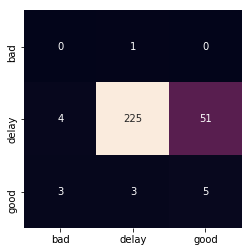

In [49]:
sns.heatmap(metrics.confusion_matrix(Y_test, pipelines[0].predict(X_test)).T, 
            square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['bad','delay','good'],
            yticklabels=['bad','delay','good'])

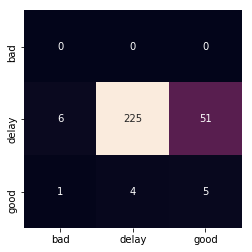

In [50]:
sns.heatmap(metrics.confusion_matrix(Y_test, pipelines[1].predict(X_test)).T, 
            square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['bad','delay','good'],
            yticklabels=['bad','delay','good'])

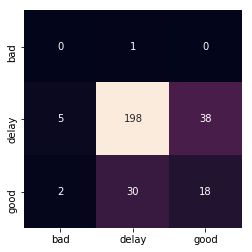

In [51]:
sns.heatmap(metrics.confusion_matrix(Y_test, pipelines[2].predict(X_test)).T, 
            square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['bad','delay','good'],
            yticklabels=['bad','delay','good'])

#### Clustering

In [52]:
# Using other data set to do clustering
clustering_data = pd.read_csv(file_path + 'clustering/Mall_Customers.csv', index_col='CustomerID')
clustering_data.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [53]:
# Select Annual Income to cluster
x = np.array(clustering_data[['Annual Income (k$)', 'Spending Score (1-100)']])
x[:5]

array([[15, 39],
       [15, 81],
       [16,  6],
       [16, 77],
       [17, 40]])

In [54]:
# Using Kmeans, cluster number = 5
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [55]:
print(kmeans.labels_)

[4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4
 3 4 3 4 3 4 1 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 1 2 0 2 0 2 1 2 0 2 0 2 0 2 0 2 1 2 0 2 0 2
 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2 0
 2 0 2 0 2 0 2 0 2 0 2 0 2 0 2]


In [56]:
# Print center point
centers = kmeans.cluster_centers_
print(centers)

[[88.2        17.11428571]
 [55.2962963  49.51851852]
 [86.53846154 82.12820513]
 [25.72727273 79.36363636]
 [26.30434783 20.91304348]]


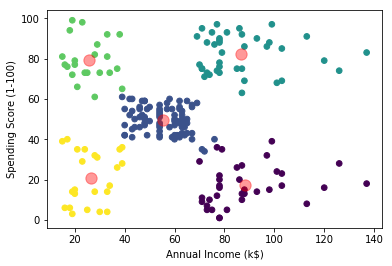

In [57]:
'''
Annual income has strong relation with spending score.
low income, high income person both have two conditions: low score and high are average
But for medium income person, they almost have medium spending score 
'''
plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, s=32, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=128, alpha=0.4);
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)');

In [58]:
# Select age to cluster
x = np.array(clustering_data[['Age', 'Spending Score (1-100)']])
x[:5]

array([[19, 39],
       [21, 81],
       [20,  6],
       [23, 77],
       [31, 40]])

In [59]:
# Using Kmeans, cluster number = 2
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(x)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [60]:
print(kmeans.labels_)

[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0
 1 0 1 1 1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


In [61]:
# Print center point
centers = kmeans.cluster_centers_
print(centers)

[[46.16521739 32.88695652]
 [28.95294118 73.62352941]]


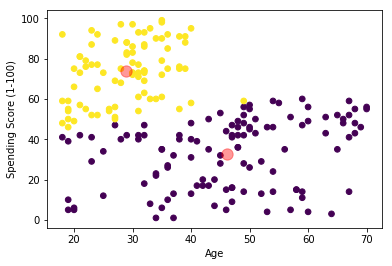

In [62]:
'''
Younge person has high spending score.
The older person has medium or low score
'''
plt.scatter(x[:, 0], x[:, 1], c=kmeans.labels_, s=32, cmap="viridis")
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=128, alpha=0.4);
plt.xlabel('Age')
plt.ylabel('Spending Score (1-100)');